In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import researchpy as rp
import scipy.stats as stats
from sklearn.cluster import DBSCAN

import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

import matplotlib as mpl

import warnings
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.options.display.max_rows = 4000
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Import local class
from apply_brf import SplitTrainAndPredict

In [2]:
## Define your path
PATH = r"D:\francisco_madrigal\Desktop\Tesis\modelo"

def create_path(file_path, path=PATH):
    
    return os.path.join(path, file_path)

In [3]:
## Open dictionary of crimes
crime_cat_file = open(create_path("crime_cat_dict.pkl"), "rb")
crime_cat_dict = pickle.load(crime_cat_file)

In [4]:
## Read neighborhoods DataFrame for later use
colonias = gpd.read_file(create_path(r"colonias_fixed\colonias_fixed.shp"))

## Declare the used coordinate system
colonias.crs = "epsg:4326"

## Print Coordinate Reference System (CRS)
# This is importan to homologue all crs from other georeferenced DataFrames
colonias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ver https://imbalanced-learn.org/stable/index.html

## Data Transformation

In [5]:
## Read DataFrame
matrix_crimes = pd.read_csv(create_path("base_crimenes.csv"),
                            parse_dates =['Hora'])

## Create dummies
#matrix_crimes = pd.get_dummies(matrix_crimes, columns=['id_colonia', 'day_period', 'dia_semana', 'month'],
#                               prefix=["colonia", "day_per", "weekday", "month"], sparse=True)
            

## Show the balance of crimes DataFrame
matrix_crimes.value_counts(subset=["crimen"], normalize=True).to_frame('Relative').merge(
    
    matrix_crimes.value_counts(subset=["crimen"]).to_frame('Absolute'),
    on='crimen')

,Relative,Absolute
crimen,,
0,0.985901,13576405
1,0.014099,194150


In [6]:
## Merge to locate the Municipality for each nieghborhood
matrix_crimes = matrix_crimes.merge(colonias[['id_colonia', 'alcaldi']],
                                   how='left',
                                   on='id_colonia')

## Create an empty DataFrame to save the predictions for each municipality
results_brf = pd.DataFrame({})

## Create an empty DataFrame to save all scores of applied models
all_scores = pd.DataFrame({})

## Create an empty DataFrame to save tran-test-split results
train_test_table = pd.DataFrame({})

In [7]:
matrix_crimes

,Hora,id_colonia,day_period,day,month,year,Coordinates,categoria_delito,crimen,dia_semana,indice,past_near_crimes_500mts,pay_day,no_labor_day,past_crimes,TEMP,PRCP,CO,O3,PM10,covid_dummy,area_km2,metro,metrobus,rtp,supers_minisupers,department_stores,banks,corporate_offices,restaurants,g_edu,no_healt_s,pop_per_km2,house_per_km2,alcaldi
0,2017-01-16 00:00:00,1,0,16,1,2017,NaN,NaN,0,0,61,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
1,2017-01-16 06:00:00,1,1,16,1,2017,NaN,NaN,0,0,62,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
2,2017-01-16 12:00:00,1,2,16,1,2017,NaN,NaN,0,0,63,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
3,2017-01-16 18:00:00,1,3,16,1,2017,NaN,NaN,0,0,64,0,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
4,2017-01-17 00:00:00,1,0,17,1,2017,NaN,NaN,0,1,65,1,0,0,0.0,60.65,0.0,0.760863,35.344061,45.331019,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,2825.271576,850.234460,MIGUEL HIDALGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13770550,2022-03-29 18:00:00,1814,3,29,3,2022,NaN,NaN,0,1,13879256,5,0,0,0.0,70.50,0.0,0.435759,53.043651,58.445370,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770551,2022-03-30 00:00:00,1814,0,30,3,2022,NaN,NaN,0,2,13879257,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770552,2022-03-30 06:00:00,1814,1,30,3,2022,NaN,NaN,0,2,13879258,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA
13770553,2022-03-30 12:00:00,1814,2,30,3,2022,NaN,NaN,0,2,13879259,5,0,0,0.0,73.95,0.0,0.389300,44.409722,54.773148,0,0.048810,0,0,1,0.0,0.0,1.0,0.0,0.0,12.845448,0.299020,29256.254756,10653.538146,VENUSTIANO CARRANZA


### Apply Balanced Random Forest

----------------------------------------------------------------------------------------------------
|MIGUEL HIDALGO|


Total features:  134
Observations:  637825


***TRAIN TABLE***
   Relative  Absolute
0  0.979132    624515
1  0.020868     13310


***TEST TABLE***
   Relative  Absolute
0  0.988386     31317
1  0.011614       368
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.77



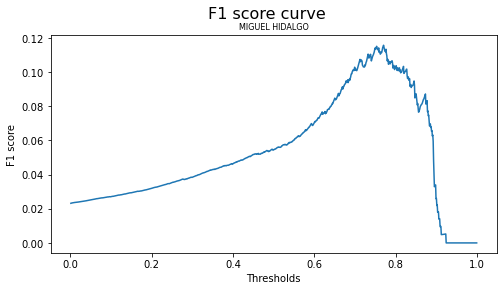

Results of Balanced Random Forest:

   F1 Score: 0.11578947368421053
   Accuracy: 0.9681868391983588
   Balanced Accuracy: 0.5784020798538368
   Average Precision Score: 0.04573578506637828


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     31317
           1       0.09      0.18      0.12       368

    accuracy                           0.97     31685
   macro avg       0.54      0.58      0.55     31685
weighted avg       0.98      0.97      0.97     31685

***************************


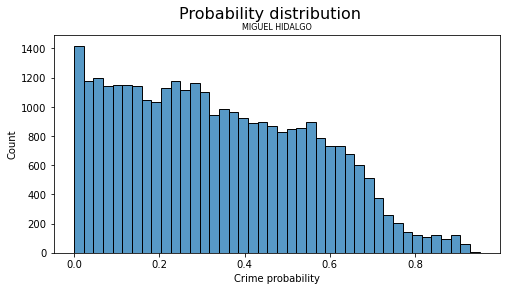

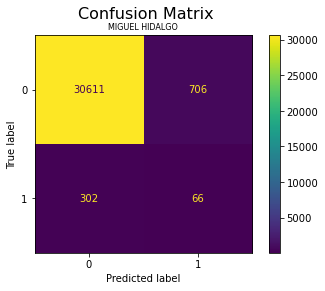

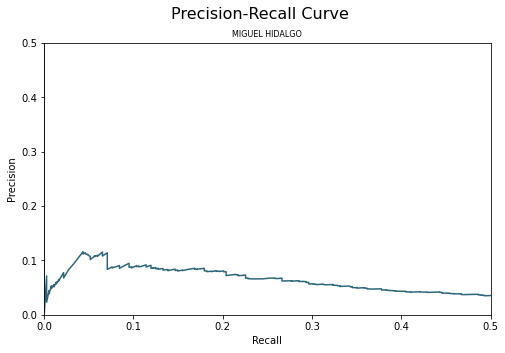

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|COYOACAN|


Total features:  200
Observations:  1115182


***TRAIN TABLE***
   Relative  Absolute
0  0.990592   1104690
1  0.009408     10492


***TEST TABLE***
   Relative  Absolute
0  0.993687     55091
1  0.006313       350
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.871



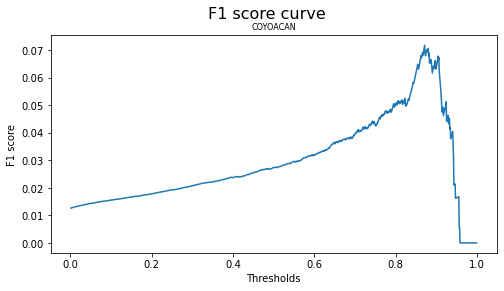

Results of Balanced Random Forest:

   F1 Score: 0.0718232044198895
   Accuracy: 0.9818185097671398
   Balanced Accuracy: 0.5493883885623008
   Average Precision Score: 0.027868588589399217


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55091
           1       0.05      0.11      0.07       350

    accuracy                           0.98     55441
   macro avg       0.52      0.55      0.53     55441
weighted avg       0.99      0.98      0.99     55441

***************************


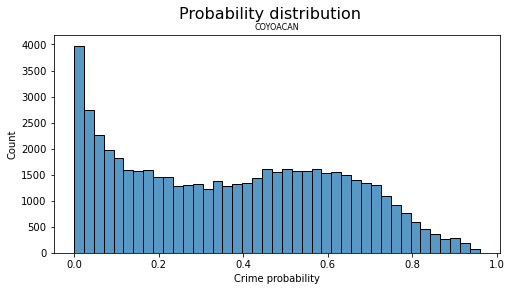

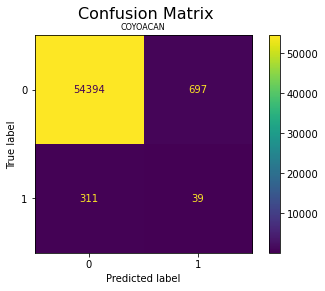

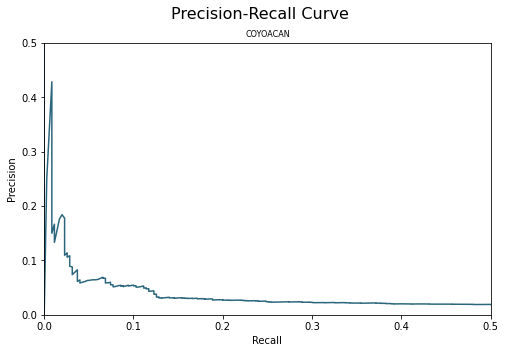

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|VENUSTIANO CARRANZA|


Total features:  127
Observations:  586864


***TRAIN TABLE***
   Relative  Absolute
0  0.979377    574761
1  0.020623     12103


***TEST TABLE***
   Relative  Absolute
0  0.986524     28771
1  0.013476       393
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.758



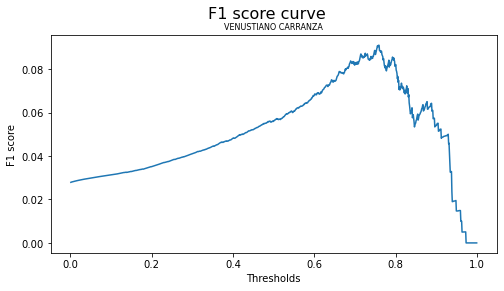

Results of Balanced Random Forest:

   F1 Score: 0.09095831077422847
   Accuracy: 0.942429022082019
   Balanced Accuracy: 0.5830615327509863
   Average Precision Score: 0.04755712740939999


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     28771
           1       0.06      0.21      0.09       393

    accuracy                           0.94     29164
   macro avg       0.52      0.58      0.53     29164
weighted avg       0.98      0.94      0.96     29164

***************************


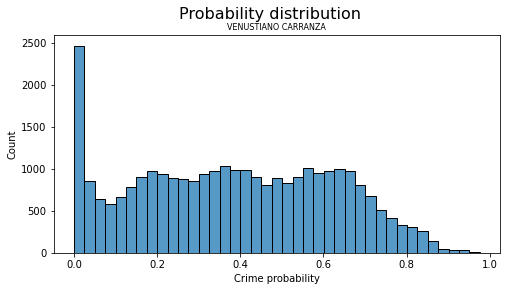

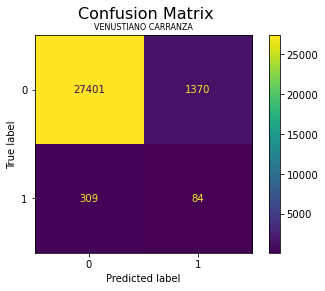

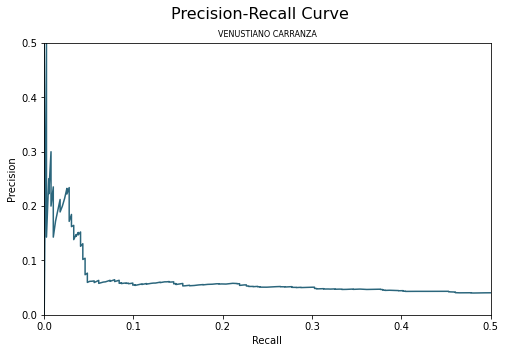

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|LA MAGDALENA CONTRERAS|


Total features:  98
Observations:  376495


***TRAIN TABLE***
   Relative  Absolute
0  0.994252    374331
1  0.005748      2164


***TEST TABLE***
   Relative  Absolute
0  0.994925     18625
1  0.005075        95
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.894



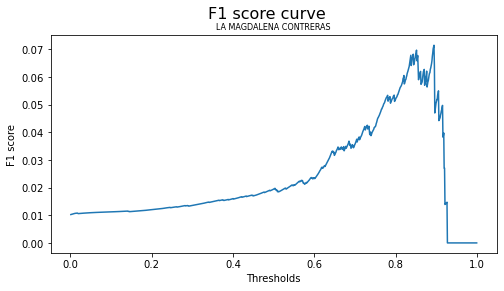

Results of Balanced Random Forest:

   F1 Score: 0.07142857142857144
   Accuracy: 0.9888888888888889
   Balanced Accuracy: 0.5388569410102437
   Average Precision Score: 0.01946995495808125


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18625
           1       0.06      0.08      0.07        95

    accuracy                           0.99     18720
   macro avg       0.53      0.54      0.53     18720
weighted avg       0.99      0.99      0.99     18720

***************************


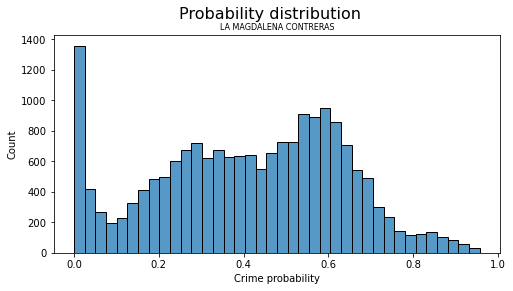

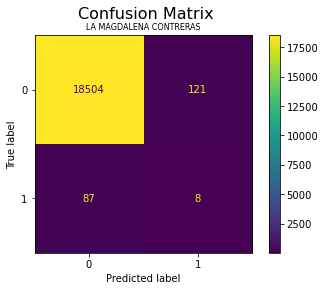

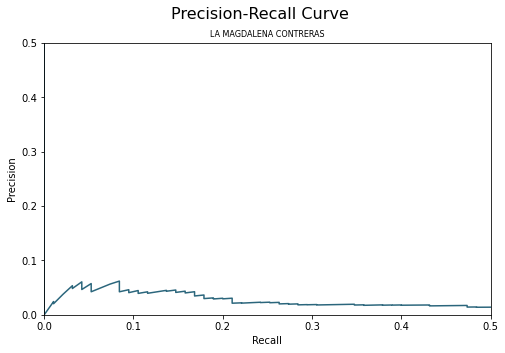

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|BENITO JUAREZ|


Total features:  110
Observations:  463677


***TRAIN TABLE***
   Relative  Absolute
0   0.97583    452470
1   0.02417     11207


***TEST TABLE***
   Relative  Absolute
0  0.985724     22716
1  0.014276       329
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.572



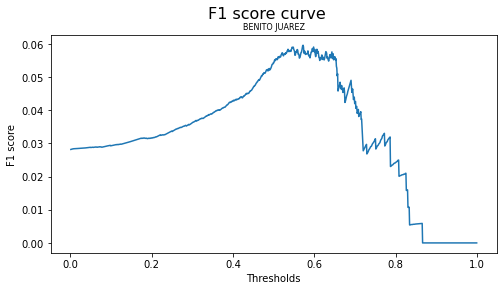

Results of Balanced Random Forest:

   F1 Score: 0.05961331901181526
   Accuracy: 0.8480364504230853
   Balanced Accuracy: 0.5964091563275568
   Average Precision Score: 0.028362641139632785


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     22716
           1       0.03      0.34      0.06       329

    accuracy                           0.85     23045
   macro avg       0.51      0.60      0.49     23045
weighted avg       0.98      0.85      0.91     23045

***************************


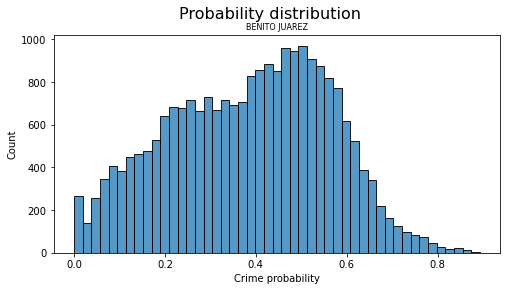

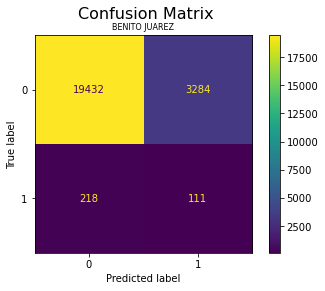

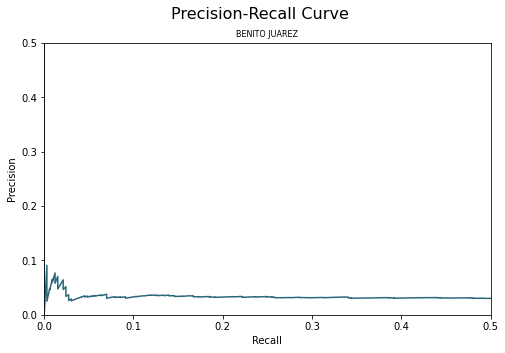

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|GUSTAVO A. MADERO|


Total features:  278
Observations:  1680123


***TRAIN TABLE***
   Relative  Absolute
0  0.987139   1658515
1  0.012861     21608


***TEST TABLE***
   Relative  Absolute
0  0.992051     82866
1  0.007949       664
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.849



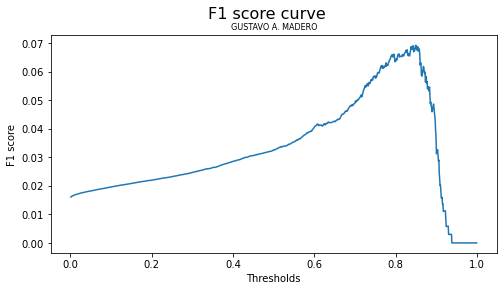

Results of Balanced Random Forest:

   F1 Score: 0.06922660897782586
   Accuracy: 0.9793966239674369
   Balanced Accuracy: 0.5414288389529445
   Average Precision Score: 0.027944469331762926


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     82866
           1       0.05      0.10      0.07       664

    accuracy                           0.98     83530
   macro avg       0.52      0.54      0.53     83530
weighted avg       0.99      0.98      0.98     83530

***************************


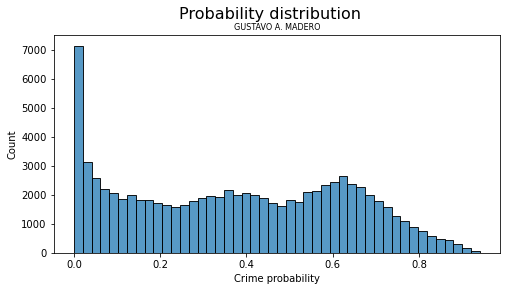

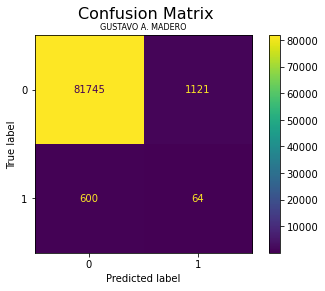

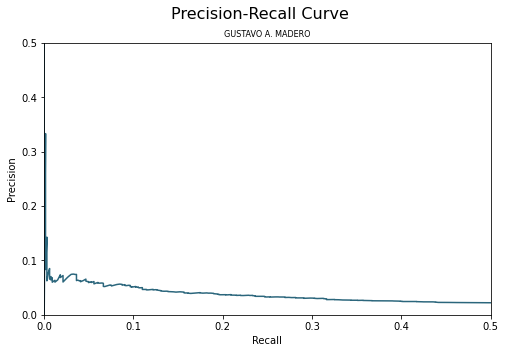

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLALPAN|


Total features:  223
Observations:  1281604


***TRAIN TABLE***
   Relative  Absolute
0   0.99284   1272428
1   0.00716      9176


***TEST TABLE***
   Relative  Absolute
0  0.994664     63382
1  0.005336       340
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.878



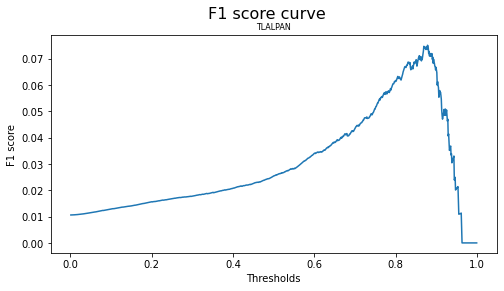

Results of Balanced Random Forest:

   F1 Score: 0.07511045655375552
   Accuracy: 0.9802893820030759
   Balanced Accuracy: 0.5673716512574548
   Average Precision Score: 0.026974394552398143


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     63382
           1       0.05      0.15      0.08       340

    accuracy                           0.98     63722
   macro avg       0.52      0.57      0.53     63722
weighted avg       0.99      0.98      0.99     63722

***************************


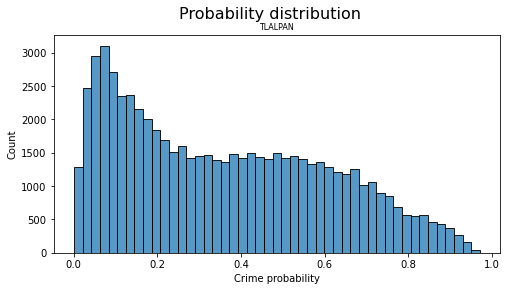

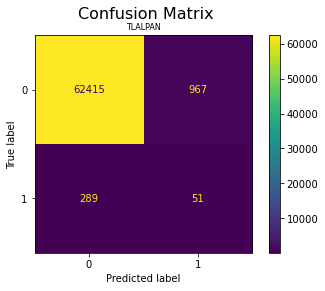

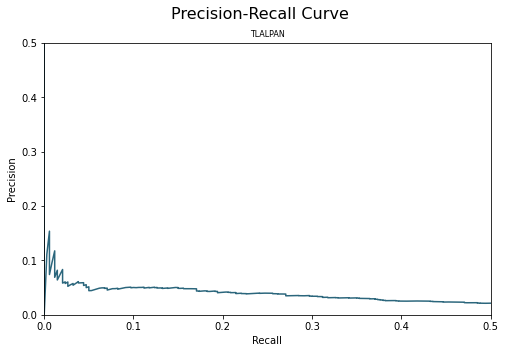

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|AZCAPOTZALCO|


Total features:  157
Observations:  803810


***TRAIN TABLE***
   Relative  Absolute
0  0.988329    794429
1  0.011671      9381


***TEST TABLE***
   Relative  Absolute
0  0.993119     39689
1  0.006881       275
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.809



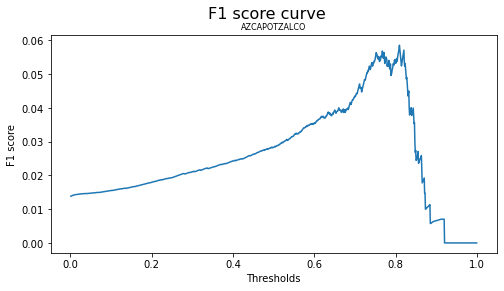

Results of Balanced Random Forest:

   F1 Score: 0.05854579792256846
   Accuracy: 0.9750525472925633
   Balanced Accuracy: 0.5468773807260542
   Average Precision Score: 0.021491566121335813


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     39689
           1       0.04      0.11      0.06       275

    accuracy                           0.98     39964
   macro avg       0.52      0.55      0.52     39964
weighted avg       0.99      0.98      0.98     39964

***************************


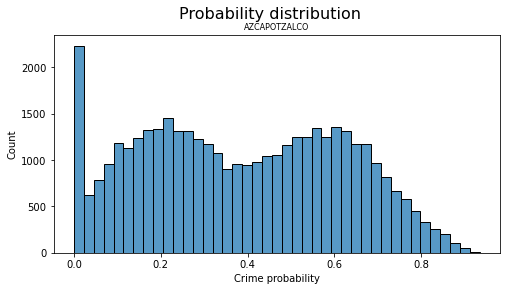

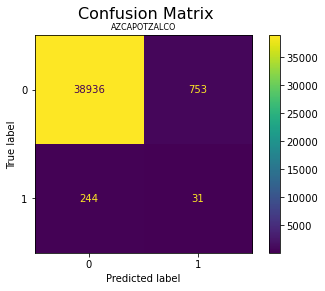

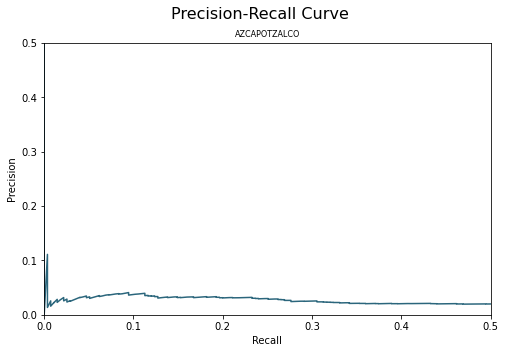

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|XOCHIMILCO|


Total features:  125
Observations:  572133


***TRAIN TABLE***
   Relative  Absolute
0  0.987859    565187
1  0.012141      6946


***TEST TABLE***
   Relative  Absolute
0  0.992617     28233
1  0.007383       210
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.881



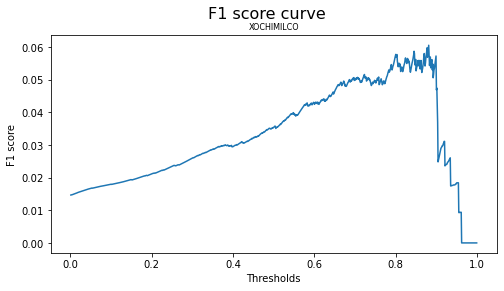

Results of Balanced Random Forest:

   F1 Score: 0.06060606060606061
   Accuracy: 0.9836515135534226
   Balanced Accuracy: 0.530932647206157
   Average Precision Score: 0.028419935919550818


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28233
           1       0.05      0.07      0.06       210

    accuracy                           0.98     28443
   macro avg       0.52      0.53      0.53     28443
weighted avg       0.99      0.98      0.98     28443

***************************


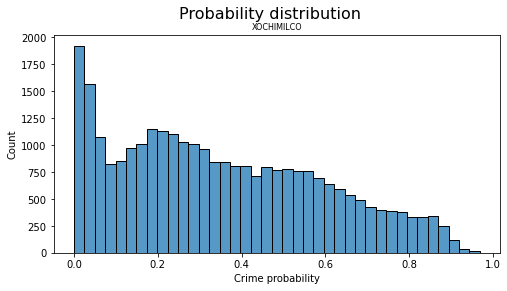

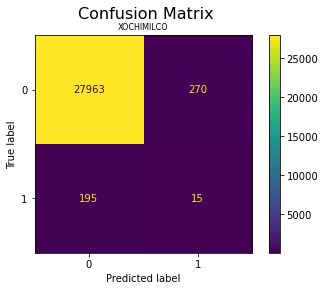

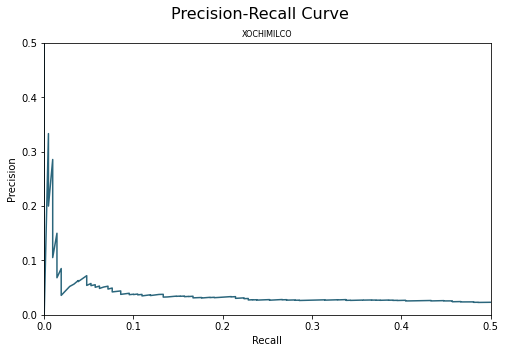

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|MILPA ALTA|


Total features:  57
Observations:  79656


***TRAIN TABLE***
   Relative  Absolute
0  0.989091     78787
1  0.010909       869


***TEST TABLE***
   Relative  Absolute
0  0.993687      3935
1  0.006313        25
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.88



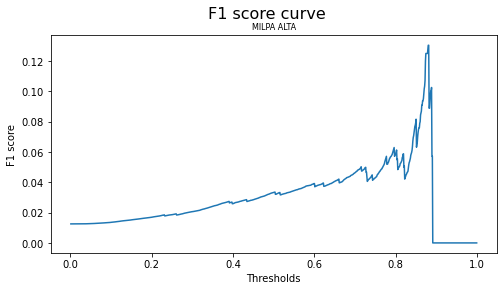

Results of Balanced Random Forest:

   F1 Score: 0.13043478260869565
   Accuracy: 0.98989898989899
   Balanced Accuracy: 0.557712833545108
   Average Precision Score: 0.03656040884445557


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3935
           1       0.14      0.12      0.13        25

    accuracy                           0.99      3960
   macro avg       0.57      0.56      0.56      3960
weighted avg       0.99      0.99      0.99      3960

***************************


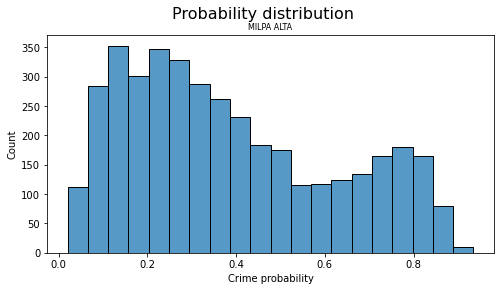

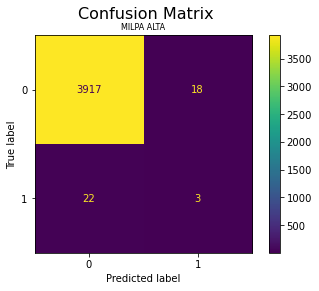

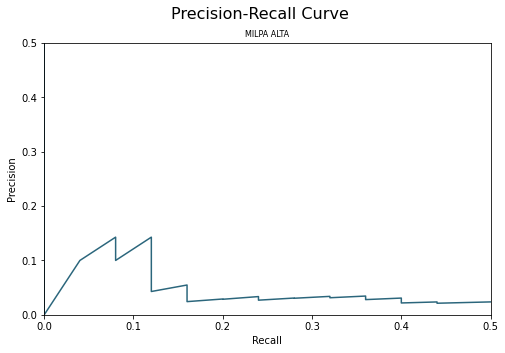

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|ALVARO OBREGON|


Total features:  296
Observations:  1810221


***TRAIN TABLE***
   Relative  Absolute
0    0.9931   1797730
1    0.0069     12491


***TEST TABLE***
   Relative  Absolute
0  0.995134     89568
1  0.004866       438
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.786



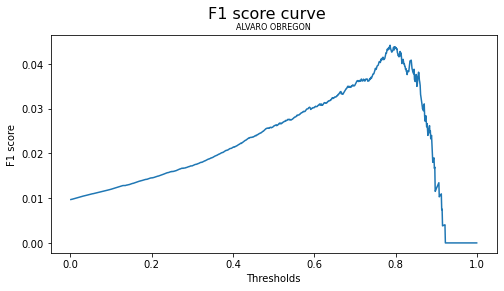

Results of Balanced Random Forest:

   F1 Score: 0.044213263979193757
   Accuracy: 0.9428371441903873
   Balanced Accuracy: 0.6089043237066076
   Average Precision Score: 0.016970335538885488


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     89568
           1       0.02      0.27      0.04       438

    accuracy                           0.94     90006
   macro avg       0.51      0.61      0.51     90006
weighted avg       0.99      0.94      0.97     90006

***************************


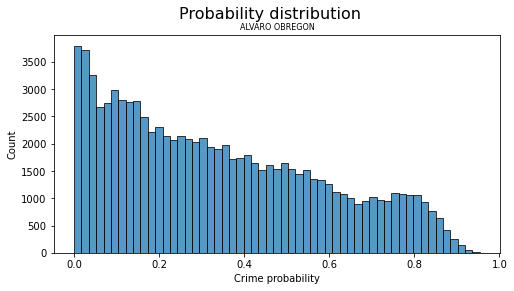

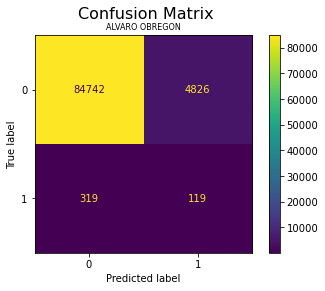

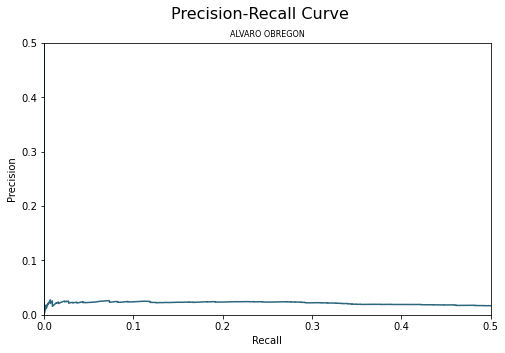

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTACALCO|


Total features:  101
Observations:  398672


***TRAIN TABLE***
   Relative  Absolute
0  0.975456    388887
1  0.024544      9785


***TEST TABLE***
   Relative  Absolute
0  0.984094     19489
1  0.015906       315
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.757



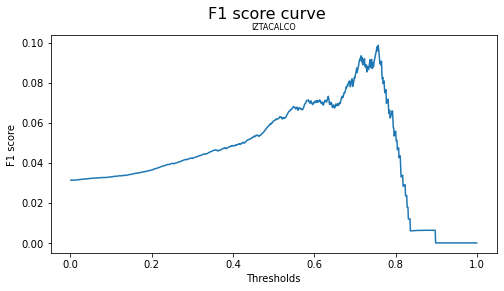

Results of Balanced Random Forest:

   F1 Score: 0.09868421052631579
   Accuracy: 0.9723288224601091
   Balanced Accuracy: 0.540871651652092
   Average Precision Score: 0.046480832158030796


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19489
           1       0.10      0.10      0.10       315

    accuracy                           0.97     19804
   macro avg       0.54      0.54      0.54     19804
weighted avg       0.97      0.97      0.97     19804

***************************


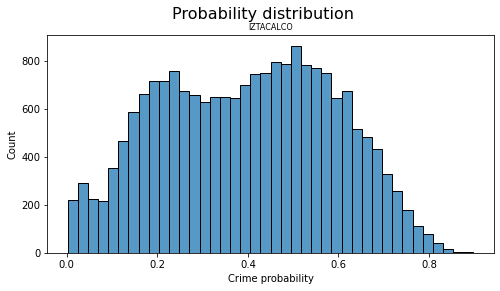

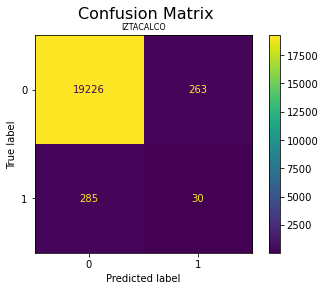

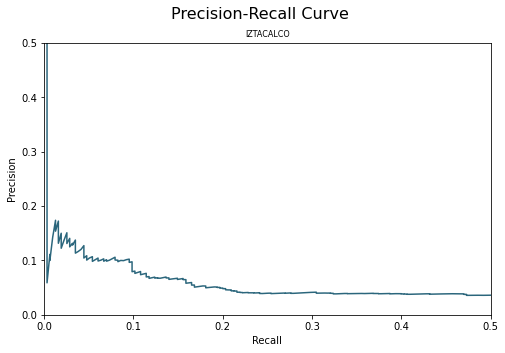

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAUHTEMOC|


Total features:  109
Observations:  458607


***TRAIN TABLE***
   Relative  Absolute
0  0.946202    433935
1  0.053798     24672


***TEST TABLE***
   Relative  Absolute
0  0.973398     22101
1  0.026602       604
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.633



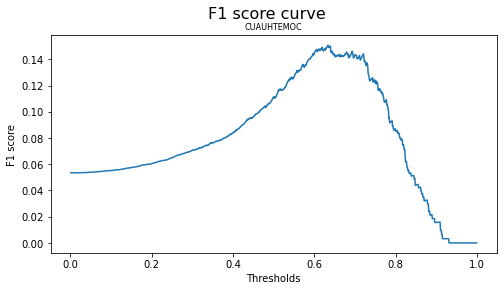

Results of Balanced Random Forest:

   F1 Score: 0.15082315454062664
   Accuracy: 0.9295749834838142
   Balanced Accuracy: 0.5918268509021347
   Average Precision Score: 0.07122850730450647


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22101
           1       0.11      0.24      0.15       604

    accuracy                           0.93     22705
   macro avg       0.54      0.59      0.56     22705
weighted avg       0.96      0.93      0.94     22705

***************************


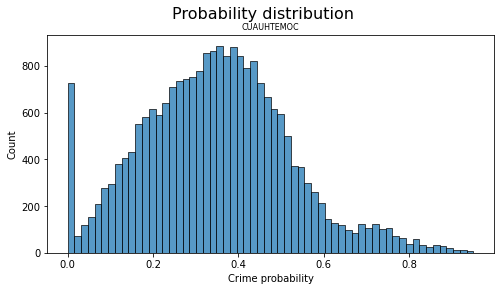

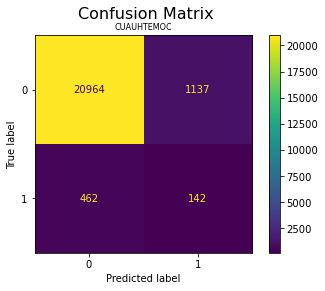

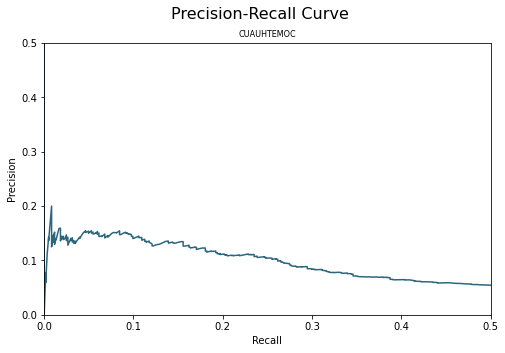

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLAHUAC|


Total features:  104
Observations:  420028


***TRAIN TABLE***
   Relative  Absolute
0  0.986708    414445
1  0.013292      5583


***TEST TABLE***
   Relative  Absolute
0   0.98918     20661
1   0.01082       226
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.825



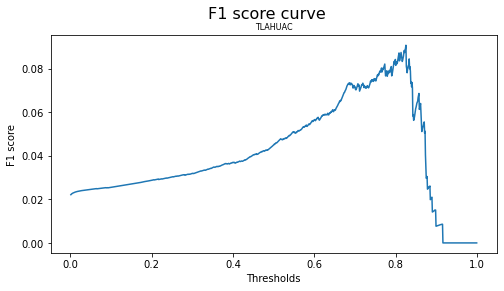

Results of Balanced Random Forest:

   F1 Score: 0.0907840440165062
   Accuracy: 0.9683535213290564
   Balanced Accuracy: 0.561683163482308
   Average Precision Score: 0.036420147320075306


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     20661
           1       0.07      0.15      0.09       226

    accuracy                           0.97     20887
   macro avg       0.53      0.56      0.54     20887
weighted avg       0.98      0.97      0.97     20887

***************************


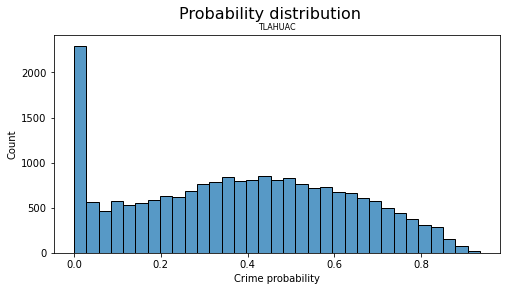

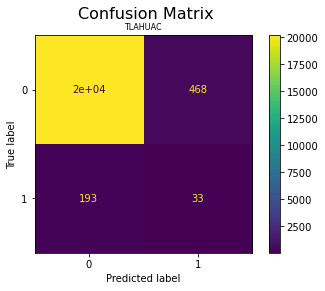

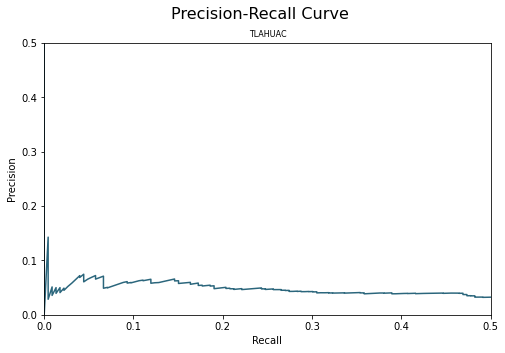

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTAPALAPA|


Total features:  339
Observations:  2122273


***TRAIN TABLE***
   Relative  Absolute
0  0.982459   2085047
1  0.017541     37226


***TEST TABLE***
   Relative  Absolute
0  0.989052    104340
1  0.010948      1155
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.765



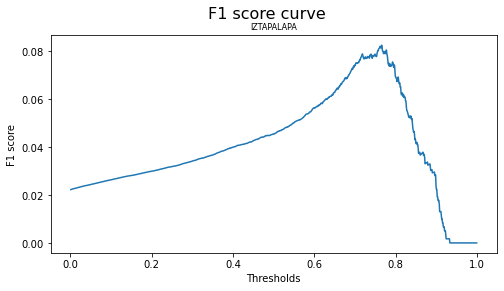

Results of Balanced Random Forest:

   F1 Score: 0.08249721293199554
   Accuracy: 0.9609934120100478
   Balanced Accuracy: 0.5650156581007645
   Average Precision Score: 0.03703434223114363


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    104340
           1       0.06      0.16      0.08      1155

    accuracy                           0.96    105495
   macro avg       0.52      0.57      0.53    105495
weighted avg       0.98      0.96      0.97    105495

***************************


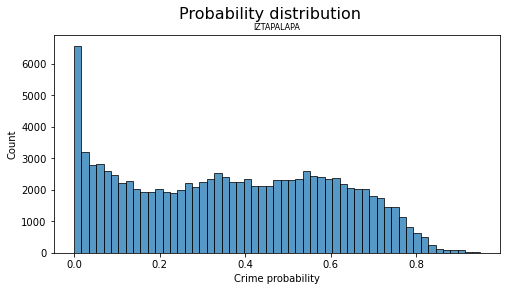

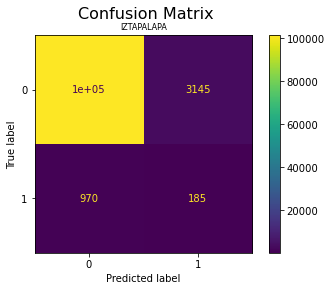

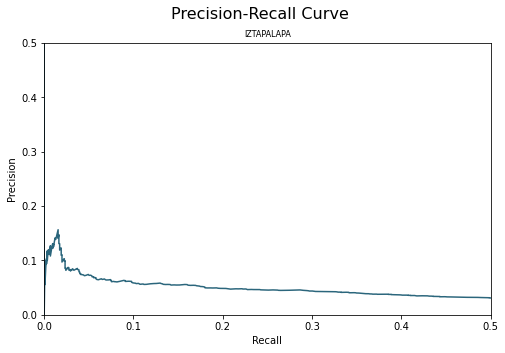

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAJIMALPA DE MORELOS|


Total features:  89
Observations:  311334


***TRAIN TABLE***
   Relative  Absolute
0  0.995789    310023
1  0.004211      1311


***TEST TABLE***
   Relative  Absolute
0  0.997481     15441
1  0.002519        39
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: None
   Threshold that max F1: 0.913



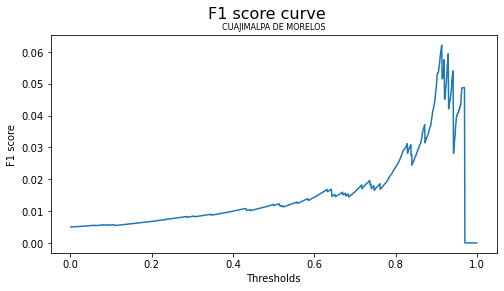

Results of Balanced Random Forest:

   F1 Score: 0.062111801242236024
   Accuracy: 0.9902454780361757
   Balanced Accuracy: 0.5603139493755387
   Average Precision Score: 0.024368167075930845


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15441
           1       0.04      0.13      0.06        39

    accuracy                           0.99     15480
   macro avg       0.52      0.56      0.53     15480
weighted avg       1.00      0.99      0.99     15480

***************************


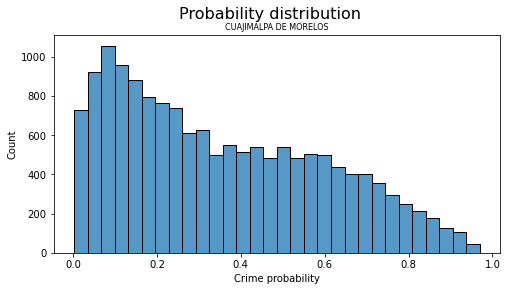

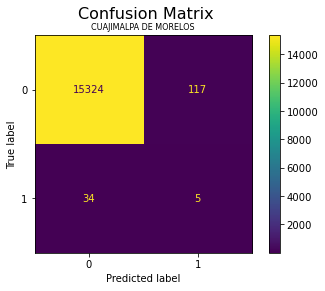

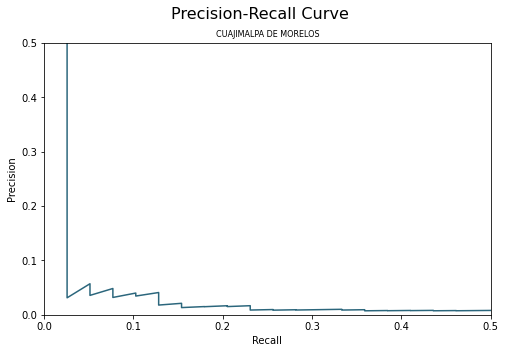

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [8]:
## Loop for every Alcaldia (Municipality) and apply the model
alcaldias_list = colonias['alcaldi'].unique()

for alcaldia in alcaldias_list:
    
    ## Initialize the class model
    model = SplitTrainAndPredict(alcaldi=alcaldia, copy_df=matrix_crimes, colonias=colonias)

    ## Create tran-test splits
    X_train, X_test, y_train, y_test, save_columns, ind_test = model.train_test_df()

    ## Apply the model
    brf, predictions, crime_prob, threshold = model.fit_my_results(X_train, X_test, y_train, y_test,
                                                                  max_feature=None)

    ## Show and save scores
    save_scores_df = model.show_my_results(y_test, crime_prob, predictions, threshold, brf, save_columns)

    ## Predict
    local_crimes_test = model.predict_crimes(X_test, ind_test, crime_prob, predictions, save_columns)

    ## Concat results
    results_brf = pd.concat([results_brf, local_crimes_test], ignore_index=True)
    all_scores = pd.concat([all_scores, save_scores_df], ignore_index=True)
    train_test_table = pd.concat([train_test_table, model.train_test_table], ignore_index=True)

In [9]:
if not os.path.isdir(create_path(r"df_results\all_cols")):
    
    os.makedirs(create_path(r"df_results\all_cols"))

## Save DataFrames results
results_brf.to_csv(create_path(r"df_results\all_cols\results_brf.csv"), index=False)

all_scores.to_csv(create_path(r"df_results\all_cols\all_scores.csv"), index=False)

train_test_table.to_csv(create_path(r"df_results\all_cols\train_test_table.csv"), index=False)

## Finally, save a reduced form of the results DataFrame and Neighborhoods
reduced_results_brf = results_brf[['id_colonia', 'day_period', 'dia_semana', 'proba_crimen']]

reduced_results_brf.to_csv(create_path(r"df_results\all_cols\reduced_results_brf.csv"), index=False)

reduced_colonias = colonias[['id_colonia', 'colonia', 'geometry']].copy()

reduced_colonias.to_csv(create_path(r"df_results\all_cols\reduced_colonias.csv"), index=False)

In [10]:
results_brf = pd.read_csv(create_path(r"df_results\all_cols\results_brf.csv"),low_memory=False,
                          parse_dates=['Hora'])

results_brf['geometry'] = gpd.GeoSeries.from_wkt(results_brf['geometry'])

results_brf = gpd.GeoDataFrame(results_brf, geometry='geometry')

Results of Balanced Random Forest:

   F1 Score: 0.07562799616490892
   Accuracy: 0.9630351000151829
   Balanced Accuracy: 0.5697164143649397
   Average Precision Score: 0.026726265242227053


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    646225
           1       0.05      0.17      0.08      5826

    accuracy                           0.96    652051
   macro avg       0.52      0.57      0.53    652051
weighted avg       0.98      0.96      0.97    652051

***************************


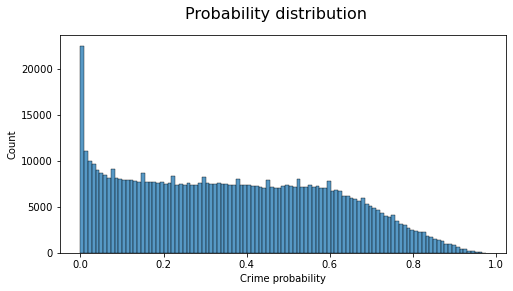

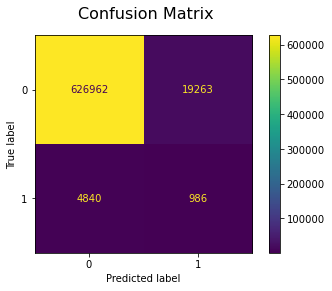

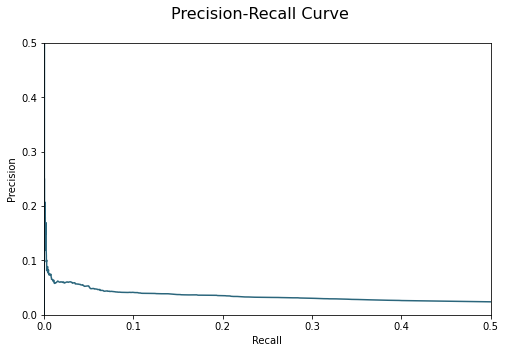

In [11]:
## Show aggregated results
model = SplitTrainAndPredict(copy_df=matrix_crimes, colonias=colonias, alcaldi="")


model.show_my_results(results_brf['crimen'], results_brf['proba_crimen'], results_brf['predictions'],
                      return_res_df=False)

### DBSCAN

We use DBSCAN to create clusters of crimes and hence reduce the spatial data. This will be help to have a better visual of the crime clusters locations. 

In [12]:
## Filter just crime observartions
crimes = matrix_crimes[matrix_crimes['crimen'] == 1].copy()

crimes['Coordinates'] = gpd.GeoSeries.from_wkt(crimes['Coordinates'])

crimes = gpd.GeoDataFrame(crimes, geometry='Coordinates')

## Create longitude and latitude series
crimes['lon'] = crimes['Coordinates'].apply(lambda p: p.x)
crimes['lat'] = crimes['Coordinates'].apply(lambda p: p.y)

## Filter just important columns
crimes = crimes[['lon','lat', 'categoria_delito']]

crimes['categoria_delito'].replace(crime_cat_dict,
                                   inplace=True)

In [13]:
## Transform to a numpyu array
coords = crimes[['lon','lat']].to_numpy()

## Establish epsilon to 50 meters
kms_per_radian = 6371.0088
epsilon = .05 / kms_per_radian

## Initiate DBSCAN
clt = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='haversine')

## Fit
model = clt.fit(np.radians(coords))

cluster_labels = model.labels_

crimes['cluster'] = cluster_labels

num_clusters = len(set(cluster_labels))
print('Number of clusters: {:,}'.format(num_clusters))

non_cluster = len(crimes[crimes['cluster'] == -1])
cluster_points = len(crimes[crimes['cluster'] != -1])

clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

## Drop non clustered data points
crimes = crimes[crimes['cluster'] != -1]

print(f'Clustered points: {cluster_points}')
print(f'Non-Clustered points: {non_cluster}')

Number of clusters: 290
Clustered points: 55066
Non-Clustered points: 139084


In [14]:
## Save DataFram results
crimes.to_csv(create_path(r"df_results\all_cols\cluster_crimes.csv"), index=False)

### Probability analysis

In [15]:
summary, results = rp.ttest(group1= results_brf['proba_crimen'][results_brf['crimen'] == 1], group1_name= "Crime",
                            group2= results_brf['proba_crimen'][results_brf['crimen'] == 0], group2_name= "Non-Crime")
print(summary)


    Variable         N      Mean        SD        SE  95% Conf.  Interval
0      Crime    5826.0  0.583563  0.195046  0.002555   0.578554  0.588573
1  Non-Crime  646225.0  0.363336  0.236428  0.000294   0.362759  0.363912
2   combined  652051.0  0.365304  0.236998  0.000293   0.364728  0.365879


In [16]:
print(results)

                  Independent t-test      results
0  Difference (Crime - Non-Crime) =        0.2202
1              Degrees of freedom =   652049.0000
2                               t =       70.8809
3           Two side test p value =        0.0000
4          Difference < 0 p value =        1.0000
5          Difference > 0 p value =        0.0000
6                       Cohen's d =        0.9328
7                       Hedge's g =        0.9328
8                   Glass's delta =        1.1291
9                     Pearson's r =        0.0874


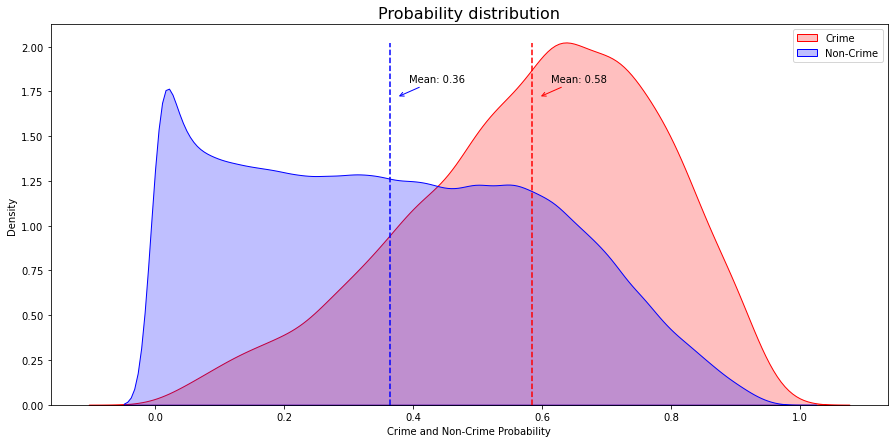

In [17]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], shade=True, ax=ax,
               color='red')
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], shade=True, ax=ax,
               color='blue')       

plt.title('Probability distribution', fontdict={'fontsize': 16})

plt.xlabel('Crime and Non-Crime Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), ymax=0.95, linestyle='--', color='red')
plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='red', shrinkB=10))

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), ymax=0.95, linestyle='--', color='blue')

plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='blue', shrinkB=10))

plt.show()

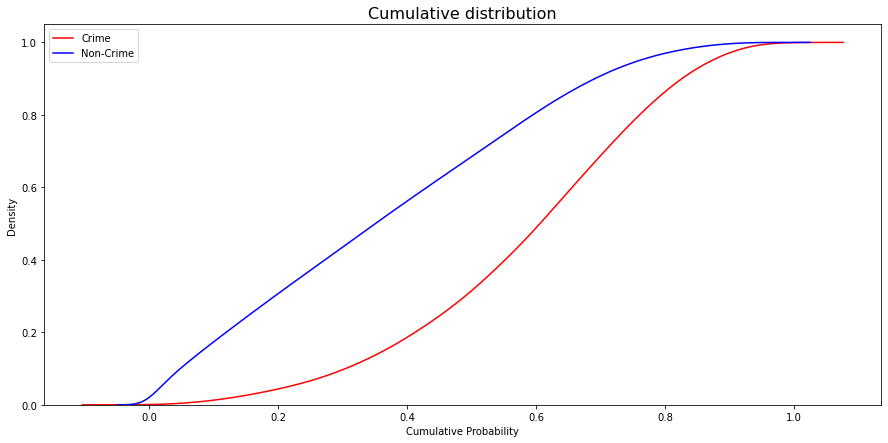

In [18]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], ax=ax,
               color='red', cumulative=True)
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], ax=ax,
               color='blue', cumulative=True)       

plt.title('Cumulative distribution', fontdict={'fontsize': 16})

plt.xlabel('Cumulative Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

plt.show()

In [19]:
results_brf_agg = results_brf.groupby(['id_colonia', 'colonia']).agg({'proba_crimen':['mean', 'median', 'std'], 
                                                                      'predictions':'mean',
                                                                      'crimen':'mean'}).reset_index()

results_brf_agg.columns = ['_'.join(col).strip() for col in results_brf_agg.columns.values]


In [20]:
results_brf_agg.sort_values(by='proba_crimen_mean', ascending=False).head(10)

,id_colonia_,colonia_,proba_crimen_mean,proba_crimen_median,proba_crimen_std,predictions_mean,crimen_mean
725,726,SAN PEDRO CUAJIMALPA (PBLO),0.879158,0.8935,0.057836,0.336111,0.016667
659,660,TLALPAN CENTRO,0.878765,0.9070,0.075161,0.653740,0.038781
584,585,SAN JERONIMO ACULCO - LIDICE (PBLO),0.867397,0.8740,0.050745,0.316667,0.030556
173,174,SAN MIGUEL TOPILEJO (PBLO),0.867236,0.8820,0.063595,0.516667,0.055556
215,216,PASEOS DE CHURUBUSCO,0.866227,0.8820,0.055820,0.933518,0.096953
757,758,SANTIAGO TULYEHUALCO (PBLO),0.854042,0.8620,0.058704,0.371191,0.052632
33,34,SAN PEDRO MARTIR (PBLO),0.852553,0.8670,0.069638,0.433333,0.033333
1712,1715,TIZAPAN_TIZAPAN SAN ANGEL,0.849611,0.8605,0.058899,0.847222,0.013889
52,53,SAN ANDRES TOTOLTEPEC (PBLO),0.845669,0.8580,0.070711,0.386111,0.022222
496,497,DEL CARMEN,0.844385,0.8920,0.108586,0.626039,0.047091


In [21]:
results_brf.reset_index(level=0, inplace=True, drop=True)

results_brf_recall = results_brf[results_brf['crimen'] == 1].copy()

results_brf_recall = results_brf_recall.groupby(results_brf['Hora'].dt.date)[['predictions']].mean().reset_index()

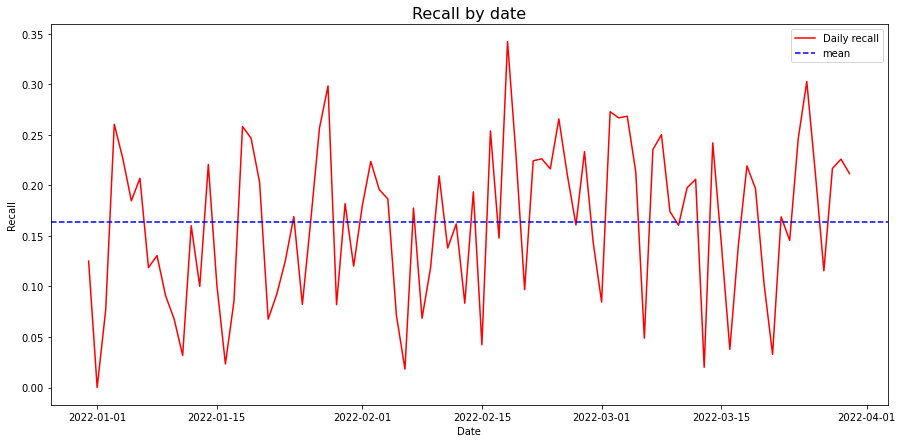

In [22]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.lineplot(data=results_brf_recall, y='predictions', x='Hora', ax=ax,
               color='red')

plt.title('Recall by date', fontdict={'fontsize': 16})

plt.xlabel('Date')

ax.axhline(y=results_brf_recall['predictions'].mean(), linestyle='--', color='blue')

plt.ylabel('Recall')
plt.legend(labels=['Daily recall', 'mean'])

plt.show()

In [23]:
results_brf_recall.groupby(results_brf['Hora'].dt.weekday)[['predictions']].mean().reset_index()

,Hora,predictions
0,0,0.162292
1,1,0.135721
2,2,0.163520
3,3,0.183307
4,4,0.171221
5,5,0.203631
6,6,0.116967


In [24]:
#https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/

#https://www.kaggle.com/prashant111/explain-your-model-predictions-with-shapley-values

#https://towardsdatascience.com/tagged/shapley-values

#https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html